# AI Action example: Smart Body Crop 

This notebook illustrates how a ML engineer develops an algorithm and deploys it in a serverless environment directly from the notebook itself. 

To make it faster to run, the training is skipped. This example reuses a pre-trained OpenPose model to identify a person in a picture, and then crops the body to highlight the desired clothing item.

### Running the notebook locally

Simply execute:
        
        $ docker run -it -p 8888:8888 -e OPENWHISK_AUTH=`cat ~/.wskprops | grep ^AUTH= | awk -F= '{print $2}'` -e OPENWHISK_APIHOST=`cat ~/.wskprops | grep ^APIHOST= | awk -F= '{print $2}'` --rm -v `pwd`:/notebooks/sf  --entrypoint jupyter-notebook adobeapiplatform/openwhisk-python3aiaction:0.11.0  --notebook-dir=/notebooks --ip 0.0.0.0 --no-browser --allow-root

> This command reads the local `~/.wskprops` and uses the Apache OpenWhisk credentials within.

In [1]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

%matplotlib inline
from inference import SmartBodyCrop
from PIL import Image
import numpy as np

In [2]:
#model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"
model_url = "models/optimized_openpose.pb"
inf = SmartBodyCrop(model_url = model_url)

## Download the deep learning (open pose) model


In [4]:
!mkdir -p models
# Comment the line bellow downloading the model, once you have it locally.
!curl -L https://www.dropbox.com/s/2dw1oz9l9hi9avg/optimized_openpose.pb -o models/optimized_openpose.pb

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  1204    0  1204    0     0    983      0 --:--:--  0:00:01 --:--:-- 1175k
100  199M  100  199M    0     0  13.8M      0  0:00:14  0:00:14 --:--:-- 19.5M


245


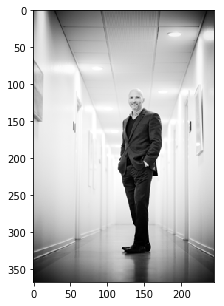

In [23]:
image = Image.open('fashion-men-1.jpg')
image.thumbnail( (368,368) )
print(image.size[0])
image = np.asarray(image)
plt.figure(figsize = (10,5))
plt.imshow(image)
plt.show()

## How algorithm sees the body

image loaded in:      0.1135
Loading the model...
model imported in :     1.5586
tf session executed in:      5.4359
pose estimated in:      0.0048


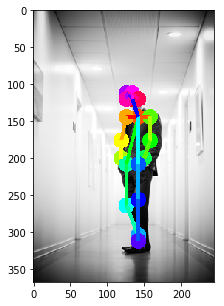

In [18]:
x = inf.detect_parts('fashion-men-1.jpg')
#x = inf.detect_parts('https://cdn.shopify.com/s/files/1/1970/6605/products/Pioneer-Camp-2017-spring-new-fashion-men-shirt-long-sleeve-brand-clothing-quality-cotton-soft-shirt_e262fa2c-a279-4190-9cf7-707982189e9e.jpg?v=1501310825')
plt.figure(figsize=(10,5))
plt.imshow(x)
plt.show()

## Bodycrop based on detected body parts

image (3840x5760) loaded in:      0.1047
Loading the model...
model imported in :     1.4202
tf session executed in:      5.4498
pose estimated in:      0.0051
image cropped in:      0.0002


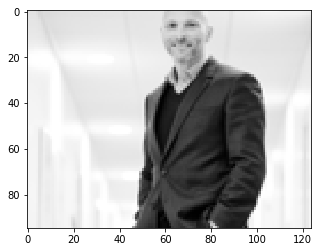

CPU times: user 8.79 s, sys: 1.87 s, total: 10.7 s
Wall time: 5.78 s


In [20]:
%%time
x, coordinates, imgpath = inf.infer('fashion-men-1.jpg','Eyes','Hips')
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

### Draw the crop coordinates on the original image

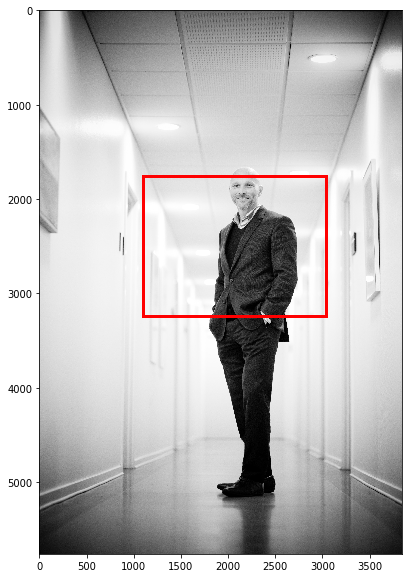

In [22]:
img = Image.open('fashion-men-1.jpg')

# Create figure and axes
fig,ax = plt.subplots(1,figsize=(14,10))
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle(
    (coordinates.get('x'),coordinates.get('y')),
    coordinates.get('width'),coordinates.get('height'),
    linewidth = 3, 
    edgecolor = 'r',
    facecolor = 'none')

# Add the patch to the Axes
ax.add_patch(rect)
plt.show()

## Test with a remote image 

image downloaded in :     0.3233
image (2192x4299) loaded in:      0.4292
Loading the model...
model imported in :     1.6012
tf session executed in:      5.5260
pose estimated in:      0.0030
image cropped in:      0.0001


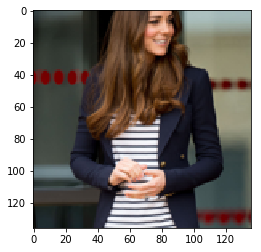

In [24]:
# https://i.pinimg.com/736x/eb/61/fa/eb61fa047dcd0a20001392c13da93709--mens-fashion-blog-mens-fashion-styles.jpg
# 2192x4299 - https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg
x, coordinates, imgpath = inf.infer('https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg',
                           'Eyes',
                           'Hips')
plt.figure(figsize = (8,4))
plt.imshow(x)
plt.show()

# Deploy the algorithm as a function

## 1. Write the function

The function expects the following parameters as input:
* `model_url` - the location of the model
* `image` - the image location. It can be given as a request object, or a location string (provided no extra authorization headers are required to read the file). I.e. 
  ```javascript
  {
      uri: "https://...",
      headers: {
          "Authorization": "Bearer ...",
      }
  }
  ```
* `from_upper` - the upper part of the body to start the crop from. I.e. _Eyes_, _Nose_, _Neck_
* `to_lower` - the lower part of the body to stop the crop at. I.e. _Hip_, _Knees_, _Ankles_

For flexibility, this function returns only the information needed to crop the body. I.e. 
```javascript
{
  X: 100,
  Y: 100,
  W: 200,
  H: 100
}
```

On the premise that the cropped image may exceed the max response size of an action, the actual cropping may be performed by another action, which should upload the cropped image to a blob storage. Bellow is the code that can crop the image based on the coordinates 

```python
from PIL import Image
import os

img_crop = Image.open(local_image_path)

img_crop = img_crop.crop(
    (coordinates.get('X'),                              # left 
     coordinates.get('Y'),                              # upper
     coordinates.get('X') + coordinates.get('W'),       # right
     coordinates.get('Y') + coordinates.get('H')))      # lower
     
img_crop_filename = (os.environ.get('__OW_ACTIVATION_ID') or '_local') + ".jpg"
img_crop_path = '/tmp/' + img_crop_filename

img_crop.save(img_crop_path, "JPEG", optimize=True)

print("The cropped image has been saved in:", img_crop_path)
```

In [25]:
%%writefile smart_body_crop.py

from inference import SmartBodyCrop
import os

def action_handler(args):
    print(args)
    model_url = args.get('model_url')
    
    body_crop = SmartBodyCrop(model_url = model_url)
    print("SmartBodyCrop.initialized=", SmartBodyCrop.initialized)
    
    crop_img, crop_coordinates, local_image_path = body_crop.infer(
                    args.get('image'), 
                    args.get('from_upper'), 
                    args.get('to_lower'))
    
    # if you want to crop the image, you can insert the code demonstrated above
    # then return the image as a base64 encoded string in the response body
    
    return {
        'X': crop_coordinates.get('x'),
        'Y': crop_coordinates.get('y'),
        'W': crop_coordinates.get('width'),
        'H': crop_coordinates.get('height')
    }
    

Overwriting smart_body_crop.py


### Test the function locally

In [26]:
%%time
from smart_body_crop import action_handler
action_response = action_handler({ 
    'model_url': model_url,
    'image': "https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg",
    'from_upper': 'Eyes',
    'to_lower': 'Elbows'})

print(action_response)

{'model_url': 'models/optimized_openpose.pb', 'image': 'https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg', 'from_upper': 'Eyes', 'to_lower': 'Elbows'}
SmartBodyCrop.initialized= False
image downloaded in :     0.1114
image (2192x4299) loaded in:      0.2350
Loading the model...
model imported in :     1.5238
tf session executed in:      5.0700
pose estimated in:      0.0056
image cropped in:      0.0002
{'H': 1028.0217391304348, 'Y': 467.2826086956522, 'W': 1031.5294117647059, 'X': 550.9304812834225}
CPU times: user 6.18 s, sys: 1.88 s, total: 8.06 s
Wall time: 5.35 s


### Verify that the returned coordinates are correct

image downloaded in :     0.1307
(2192, 4299)


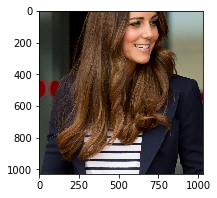

In [27]:
imgpath = inf._download_image('https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg')
image = Image.open(imgpath)
print(image.size)

img_crop = image.crop(
    (action_response.get('X'),                              # left 
     action_response.get('Y'),                              # upper
     action_response.get('X') + action_response.get('W'),       # right
     action_response.get('Y') + action_response.get('H')))      # lower

image = np.asarray(img_crop)
plt.figure(figsize = (7,3))
plt.imshow(image)
plt.show()

## 2. Configure Apache OpenWhisk as the FaaS Provider 

In [28]:
%%bash
which wsk && exit
echo "Installing wsk CLI ..."
curl -L https://github.com/apache/incubator-openwhisk-cli/releases/download/latest/OpenWhisk_CLI-latest-linux-amd64.tgz -o /tmp/wsk.tgz 
tar xvfz /tmp/wsk.tgz -C /tmp/
mv /tmp/wsk /usr/local/bin

Installing wsk CLI ...
wsk
NOTICE.txt
README.md
LICENSE.txt


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   626    0   626    0     0   1501      0 --:--:-- --:--:-- --:--:--  1538
100 3845k  100 3845k    0     0  1344k      0  0:00:02  0:00:02 --:--:-- 2202k


#### Configure Apache OpenWhisk credentials

Use `OPENWHISK_AUTH` and `OPENWHISK_APIHOST` environment variables.

In [29]:
from pathlib import Path
import os
home = str(Path.home())
file = open(home + "/.wskprops","w") 
file.write('AUTH=' + os.environ.get('OPENWHISK_AUTH') + "\n")
file.write('APIHOST=' + os.environ.get('OPENWHISK_APIHOST') + "\n")
file.close()

## 3. Deploy the function

The function must ZIP the other dependent python scripts used to train the model. The action code must be placed in a file called `__main__.py`.

In [30]:
%%bash
mkdir -p action_package

cp smart_body_crop.py action_package/__main__.py
cp *.py action_package/
cd action_package && zip -9 -r ../action.zip ./

  adding: smart_body_crop.py (deflated 58%)
  adding: common.py (deflated 68%)
  adding: inference.py (deflated 73%)
  adding: __main__.py (deflated 58%)


In [31]:
model_url = "https://s3.amazonaws.com/rt-dev-public-models/openpose/2dw1oz9l9hi9avg/optimized_openpose.pb"

In [32]:
%%bash -s "$model_url"

wsk action update smart_body_crop action.zip --main action_handler  \
    --param model_url "$1" \
    --param from_upper Eyes \
    --param to_lower Hips \
    --memory 3891 \
    --docker adobeapiplatform/openwhisk-python3aiaction:0.11.0

ok: updated action smart_body_crop


In [33]:
# !wsk action get smart_body_crop

## 4. Invoke the function

In [34]:
!wsk action invoke smart_body_crop --param image "https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg" \
  --param from_upper Eyes --param to_lower Elbows
# !wsk action invoke smart_body_crop --param image "https://i.pinimg.com/236x/17/1c/a6/171ca6b06111529aa6f10b1f4e418339--style-men-my-style.jpg" \
#   --param from_upper Eyes --param to_lower Elbows

ok: invoked /_/smart_body_crop with id 6c1536170686492a9536170686692a59


### Note on first run 
On initial run the function has to:
* download the model
* initialize tensorflow 

These steps will take a few seconds.

In [35]:
!wsk activation get 6c1536170686492a9536170686692a59

ok: got activation 6c1536170686492a9536170686692a59
{
    "namespace": "bladerunner-test",
    "name": "smart_body_crop",
    "version": "0.0.20",
    "subject": "bladerunner-test",
    "activationId": "6c1536170686492a9536170686692a59",
    "start": 1545333346300,
    "end": 1545333353046,
    "duration": 6746,
    "response": {
        "status": "success",
        "statusCode": 0,
        "success": true,
        "result": {
            "H": 1028.0217391304348,
            "W": 1031.5294117647059,
            "X": 550.9304812834225,
            "Y": 467.2826086956522
        }
    },
    "logs": [],
    "annotations": [
        {
            "key": "path",
            "value": "bladerunner-test/smart_body_crop"
        },
        {
            "key": "waitTime",
            "value": 2787
        },
        {
            "key": "kind",
            "value": "blackbox"
        },
        {
            "key": "limits",
            "value": {
                "concurrency": 1,
            

### Invoke the action again

This time it should respond much faster as it has been pre-warmed.

In [36]:
%%time
!wsk action invoke smart_body_crop --param image "https://i.pinimg.com/originals/9c/96/87/9c968732595e965619ef7b0b7e4807e0.jpg" \
  --param from_upper Eyes --param to_lower Elbows -b

ok: invoked /_/smart_body_crop with id fd729b5d47e6415ab29b5d47e6915aa9
{
    "activationId": "fd729b5d47e6415ab29b5d47e6915aa9",
    "annotations": [
        {
            "key": "limits",
            "value": {
                "concurrency": 1,
                "logs": 10,
                "memory": 3891,
                "timeout": 60000
            }
        },
        {
            "key": "path",
            "value": "bladerunner-test/smart_body_crop"
        },
        {
            "key": "kind",
            "value": "blackbox"
        },
        {
            "key": "waitTime",
            "value": 6
        }
    ],
    "duration": 2160,
    "end": 1545333364902,
    "logs": [],
    "name": "smart_body_crop",
    "namespace": "bladerunner-test",
    "publish": false,
    "response": {
        "result": {
            "H": 1028.0217391304348,
            "W": 1031.5294117647059,
            "X": 550.9304812834225,
            "Y": 467.2826086956522
        },
        "status": "suc